# EMToolKit Dashboard Example

## This software shows the user how to use the dashboard

### Import Statements

In [1]:
# Standard library imports
import importlib
import os.path
import pickle
import time
from sys import path

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import matplotlib
from sunpy.map import Map
from sunpy.net import Fido, attrs as a, vso
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection
from astropy import wcs

# EMToolKit specific imports
import EMToolKit
import EMToolKit.visualization
import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_object
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper

# Reloading modules (if necessary)
importlib.reload(EMToolKit)
importlib.reload(EMToolKit.visualization)

# Jupyter/IPython specific commands
%matplotlib widget
# matplotlib.use("qt5Agg")
# jupyter nbextension enable --py widgetsnbextension

# Configuration settings
plt.rcParams.update({'font.size': 18, 'figure.figsize': [20, 15], 'image.origin': 'lower'})
np.set_printoptions(linewidth=128)

# Setting the base path
base_path = "../"
emtk_path = base_path + 'code/'
path.append(emtk_path)

# Display HTML for notebook width
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

# Initialization
em_collection = 0


/Users/cgilbert/vscode/EMToolkit/EMToolKit/EMToolKit/schemas/util.py:37: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(fastmath=True, parallel=True)


In [2]:
# These flags tell the program not to recalculate the data if it has already been calculated
redownload = False
recalc_sparse = False
recalc_simple = False

### Download the Imagery

In [3]:
xlen = 400*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 400*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -0*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -0*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

sdo_data_dir = base_path+"data/20120711/" # Place to put data files. You'll need to change it or create these subdirectories
# Example data to load. We'll use a part of the field of view observed by the Hi-C rocket in 2012.
date='2012/07/11 18:54:00'
if not os.path.exists(sdo_data_dir):
    os.makedirs(sdo_data_dir)
paths = [sdo_data_dir + path for path in os.listdir(sdo_data_dir)
         if (os.path.isfile(os.path.join(sdo_data_dir, path)) and ".fits" in path)]
print(f"Searching for images from {date}...")

if len(paths) == 0 or redownload:
# Commands for initial data download. Comment out once that's successful.
# VSO can sometimes be a bit flakey here, in my experience, may require multiple tries:
    dl_paths = []
    passbands = np.array([94,131,171,193,211,335])*u.angstrom

    # Combine the wavelength queries using the | operator
    wavelength_query = a.Wavelength(passbands[0])
    for band in passbands[1:]:
        wavelength_query |= a.Wavelength(band)

    qry = Fido.search(a.Time(TimeRange(date,12*u.s)),a.Instrument('AIA'),wavelength_query)

    print("Downloading images...")
    Fido.fetch(qry,path=sdo_data_dir, max_conn=len(passbands)+1)

paths = [sdo_data_dir + path for path in os.listdir(sdo_data_dir)
         if (os.path.isfile(os.path.join(sdo_data_dir, path)) and ".fits" in path)]

print(f"Found {len(paths)} images on disk.")
# asdf= [print(x) for x in paths]


Searching for images from 2012/07/11 18:54:00...
Found 6 images on disk.


In [4]:
# Load the AIA data:
maps = load_from_paths(paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
[maps,errs,trlogts,tresps] = aia_wrapper(maps)

# Make data sequence from AIA data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA data:
em_collection = emtk.em_collection(datasequence)


In [5]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

do_plot = False

if do_plot:
    fig, axs = plt.subplots(2, 3)
    axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
    axs[0,0].set(title='AIA 193 Angstrom')
    axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
    axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

    axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
    axs[0,1].set(title='AIA 335 Angstrom')
    axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
    axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

    axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
    axs[0,2].set(title='AIA 94 Angstrom')
    axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
    axs[1,2].set(title='AIA 94 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

### Compute the Differential Emission Measures

In [6]:
# Compute the DEM for Cheung et al. sparse EM method:
# Make DEM sequence from the DEM and add it to the collection:
pk_file = f'{sdo_data_dir}/sparse_em_demsequence.pkl'

if os.path.exists(pk_file) and not recalc_sparse:
    with open(pk_file, 'rb') as file:
        (sparse_em_demsequence, spars_out) = pickle.load(file)
else:
    tstart=time.time()
    spars_out = sparse_em_wrapper(datasequence)
    sparse_em_demsequence = emtk.dem_model(*spars_out, sparse_em_wrapper)
    print('Sparse method took',time.time()-tstart)
    with open(pk_file, 'wb') as file:
        pickle.dump((sparse_em_demsequence, spars_out), file)

spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm = spars_out
em_collection.add_model(sparse_em_demsequence)

In [7]:
# Compute the DEM for Plowman & Caspi simple_reg_dem method:
# Make DEM sequence from the DEM and add it to the collection:
pk_file = f'{sdo_data_dir}/simple_reg_demsequence.pkl'
# if(('simple_reg_demsequence' in locals()) == False):
recalc = False
if os.path.exists(pk_file) and not recalc_simple:
    with open(pk_file, 'rb') as file:
        (simple_reg_demsequence, simpl_out) = pickle.load(file)
else:
    tstart=time.time()
    simpl_out = simple_reg_dem_wrapper(datasequence)
    print('Simple method took',time.time()-tstart)
    simple_reg_demsequence = emtk.dem_model(*simpl_out, simple_reg_dem_wrapper)
    with open(pk_file, 'wb') as file:
        pickle.dump((simple_reg_demsequence, simpl_out), file)

em_collection.add_model(simple_reg_demsequence)
simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm = simpl_out
# print(simpl_out)

In [8]:
spars_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=spars_algorithm)

In [9]:
simpl_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=simpl_algorithm)

In [10]:
def calc_resids(synthdata, em_collection):# Calculate the residuals and Chi squared:
    ndata = len(synthdata)
    resids = []
    datasequence = em_collection.data()
    chi2 = 0
    [nx,ny] = datasequence[0].data.shape
    for seq in datasequence: [nx,ny] = [np.min([seq.data.shape[0],nx]),np.min([seq.data.shape[1],ny])]
    for i in range(0,ndata):
        exptime = datasequence[i].meta['exptime']
        nx = np.min([synthdata[i].data.shape[0],datasequence[i].data.shape[0],datasequence[i].uncertainty.array.shape[0]])
        ny = np.min([synthdata[i].data.shape[1],datasequence[i].data.shape[1],datasequence[i].uncertainty.array.shape[1]])
        resids.append(((exptime*synthdata[i].data[0:nx,0:ny]-datasequence[i].data[0:nx,0:ny])/datasequence[i].uncertainty.array[0:nx,0:ny])**2)
        chi2 += np.mean(resids)/ndata
    return resids, chi2

spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
print('simple_reg_dem Chi squared = ',simpl_chi2, '\nspars_em Chi squared = ',spars_chi2)

simple_reg_dem Chi squared =  0.8921242680363539 
spars_em Chi squared =  1.4311245480481973


In [11]:
do_resid_plots = False
if do_resid_plots:
    # Plot Residuals:
    fig = plt.figure(figsize=[20,12])
    plt.suptitle('Residuals for '+simpl_algorithm)
    for i in range(0,6):
        ax1 = fig.add_subplot(2,3,i+1)
        ax1.imshow(simpl_resids[i],vmin=0,vmax=5)
        ax1.set(title=em_collection.data()[i].meta['channel'])

    # Plot Residuals:
    fig = plt.figure(figsize=[20,12])
    plt.suptitle('Residuals for '+spars_algorithm)
    for i in range(0,6):
        ax1 = fig.add_subplot(2,3,i+1)
        ax1.imshow(spars_resids[i],vmin=0,vmax=5)
        ax1.set(title=em_collection.data()[i].meta['channel'])

### Run the Dashboard

Output()

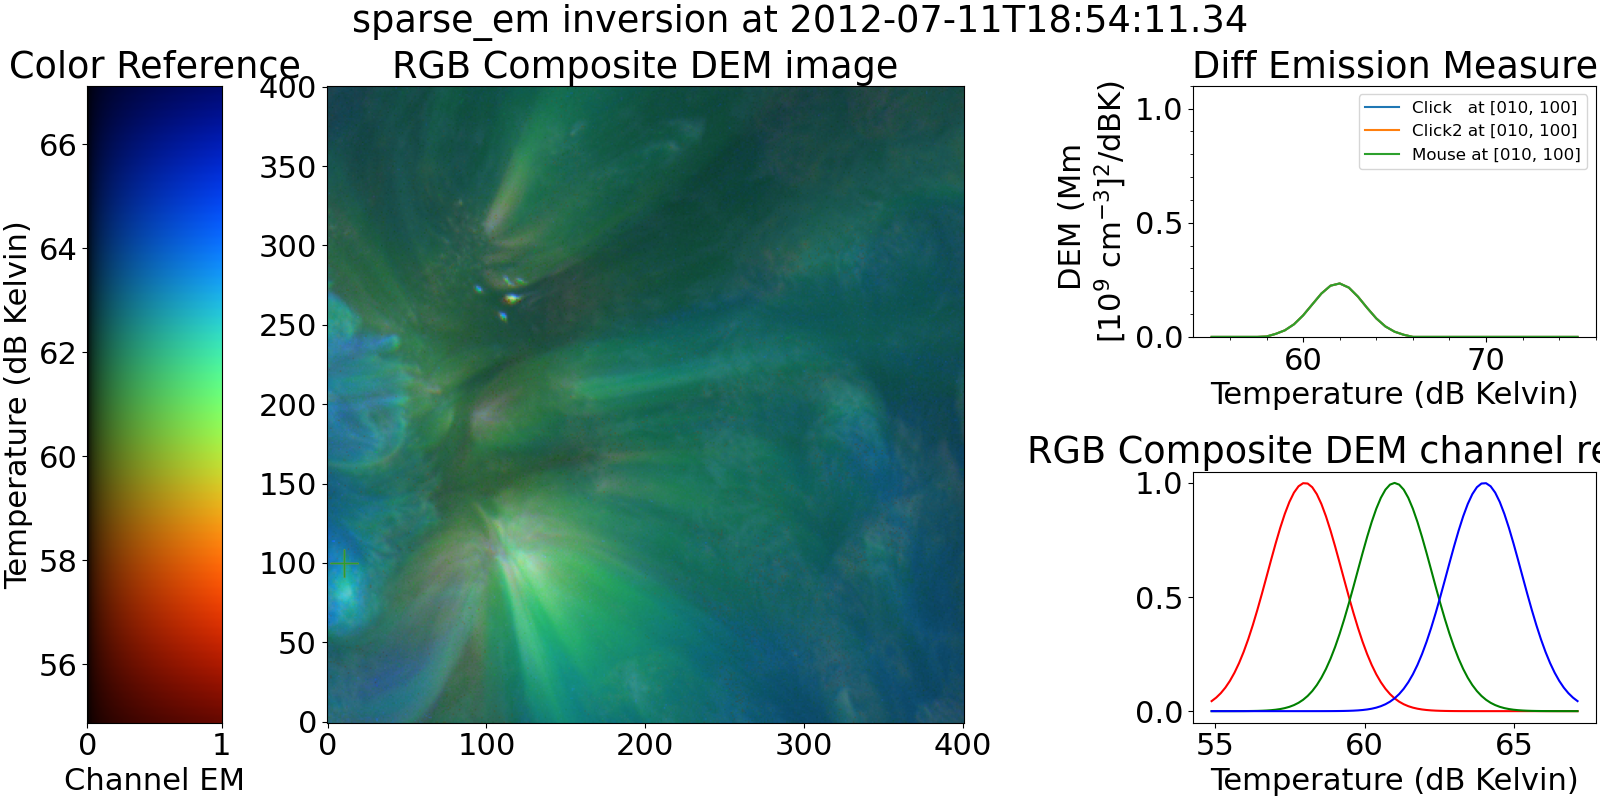

In [12]:
# Get the most recent version from the tool kit:
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_object

# Create the dashboard:
dash = dashboard_object(em_collection)
dash.display()